<xarray.Dataset>
Dimensions:         (lev: 43, lon: 360)
Coordinates:
  * lev             (lev) float32 5.0 15.0 25.0 ... 1.106e+03 1.245e+03 1.4e+03
  * lon             (lon) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
Data variables: (12/17)
    CCSM4           (lev, lon) float64 ...
    CESM1.2         (lev, lon) float32 ...
    CESM2           (lev, lon) float32 ...
    COSMOS          (lev, lon) float64 ...
    EC_Earth3.3     (lev, lon) float32 ...
    HADGEM3         (lev, lon) float64 ...
    ...              ...
    NorESM-F        (lev, lon) float64 ...
    IPSLCM5A        (lev, lon) float32 ...
    IPSLCM5A2       (lev, lon) float32 ...
    MMM             (lev, lon) float64 ...
    MCA Late Plio   (lev, lon) float64 ...
    MCA Early Plio  (lev, lon) float64 ...
--------------------------------------------------------------------------------------------
Original data shape: (15480, 14), Cleaned data shape: (10409, 14)
----------------------------------------------

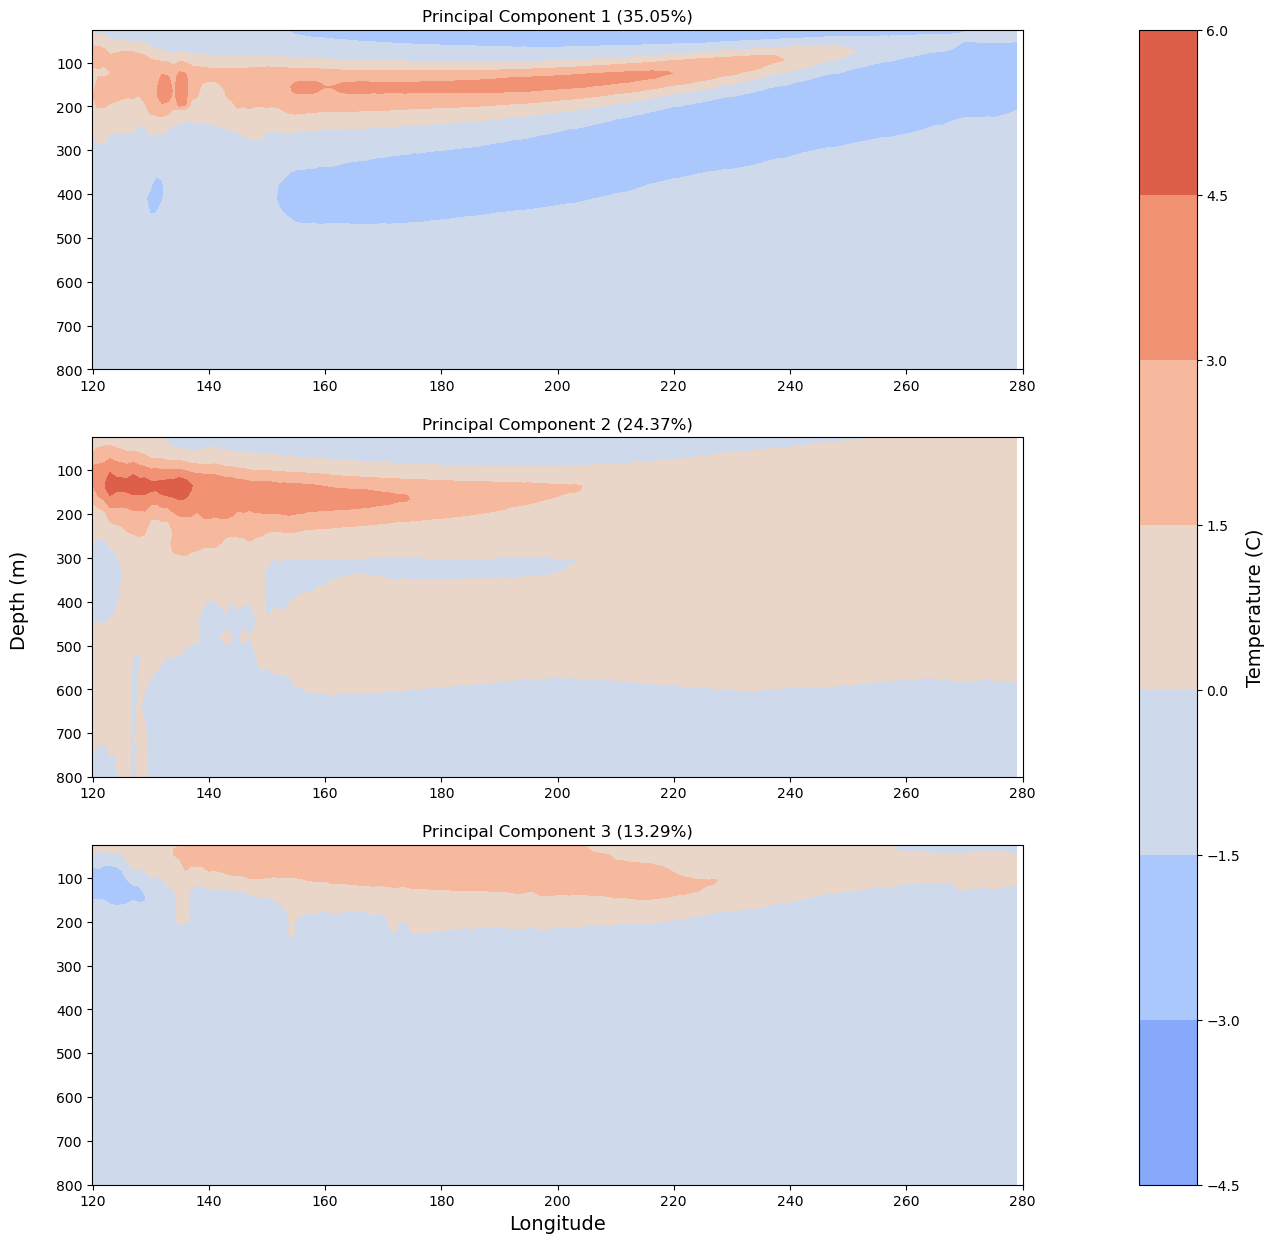

In [4]:
import xarray as xr
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/all_models.nc')
print(ds)

# Define the models to drop
models_to_drop = ['MMM', 'MCA Late Plio', 'MCA Early Plio']

# Select only the models that are not in the list
ds = ds.drop_vars(models_to_drop)

# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA Late Plio', 'MCA Early Plio']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]
print ('--------------------------------------------------------------------------------------------')
print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")
print ('--------------------------------------------------------------------------------------------')
# Perform PCA on cleaned data
pca = PCA(n_components=5)
pca_result = pca.fit_transform(clean_data_matrix)

# Reconstruct into original grid (without NaN rows)
restored_pca = np.full((data_matrix.shape[0], pca_result.shape[1]), np.nan)  # Placeholder with NaNs
restored_pca[~nan_mask] = pca_result  # Fill only valid positions

# Convert back to xarray
pca_ds = xr.Dataset({
    f'PC{i+1}': (['lev', 'lon'], restored_pca[:, i].reshape(ds.dims['lev'], ds.dims['lon']))
    for i in range(pca_result.shape[1])
})
pca_ds.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/pca_results.nc')

print("PCA completed successfully after NaN removal!")

print(pca_ds)
print(pca.explained_variance_ratio_)

# Define number of PCs to visualize
num_components = min(3, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

# Initialize a variable to store the last mappable object
last_pcm = None

for i in range(num_components):
    ax = axes[i]
    norm = plt.Normalize(vmin=-7, vmax=7)
    # Plot PCA result as an image (Depth vs. Longitude)
    pcm = ax.contourf(ds['lon'], ds['lev'], pca_ds[f'PC{i+1}'], cmap='coolwarm', norm=norm)
    last_pcm = pcm  # Store the last mappable object
    
    # Formatting
    ax.set_title(f'Principal Component {i+1} ({variance[i]:.2f}%)')
    ax.set_ylim([800, 25])
    ax.set_xlim([120, 280])

# Add a single colorbar for all subplots
cbar = fig.colorbar(last_pcm, ax=axes, orientation='vertical', fraction=0.1, pad=0.1, location='right')
ax.set_xlabel('Longitude', fontsize = 14)
fig.supylabel('Depth (m)', fontsize=14, x = 0.07)

cbar.set_label('Temperature (C)', fontsize=14,)
#plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/PCA_DepthvsLongitude_04102025.pdf', dpi=300, bbox_inches="tight")
plt.show()